In [3]:
import pandas as pd
import numpy as np

### Test and Train data 

In [82]:
data = pd.read_csv('merged_cleaned_sentiment_train.csv', delimiter = ',')
data_test = pd.read_csv('merged_cleaned_sentiment_test.csv', delimiter = ',')
data_val = pd.read_csv('merged_cleaned_sentiment_validation.csv', delimiter = ',')


### Basic Model with Vader Sentiment

In [83]:
data_features = data[['pos','neg','neu','compound']]
data_labels = data[['y_valence', 'y_arousal']]

data_features_test = data_test[['pos','neg','neu','compound']]
data_labels_test = data_test[['y_valence', 'y_arousal']]

data_features_val = data_val[['pos','neg','neu','compound']]
data_labels_val = data_val[['y_valence', 'y_arousal']]

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X_train_vader, y_train = np.array(data_features), np.array(data_labels)
X_test_vader, y_test = np.array(data_features_test), np.array(data_labels_test)
X_val_vader, y_val = np.array(data_features_val), np.array(data_labels_val)

In [85]:
reg = LinearRegression()
reg.fit(X_train_vader,y_train)
prediction = reg.predict(X_val_vader)
print(mean_squared_error(y_val, prediction))
print(r2_score(y_val, prediction))

0.964540870609685
0.022844544146133294


A very high RMSE considering our predicted values go from -1 to 1. The RMSE is half of the range. 

In [30]:
np.sum(np.sign(y_val) == np.sign(prediction))/len(y_val)

1.1004691164972635

It only guesses the sign (pos/neg) correctly 60% of the time. 

In [32]:
print(r2_score(y_val, prediction))

0.022844544146133294


There is practically no correlation between predicted and actual values. This doesn't work. 

### Basic Bigram Model with Linear Regression

In [86]:
data = pd.read_csv('merged_cleaned_sentiment_train.csv', delimiter = ',')
data_test = pd.read_csv('merged_cleaned_sentiment_test.csv', delimiter = ',')
data_val = pd.read_csv('merged_cleaned_sentiment_validation.csv', delimiter = ',')


data_lyrics_train = np.array(data['lyrics_cleaned'])
data_lyrics_test = np.array(data_test['lyrics_cleaned'])
data_lyrics_val = np.array(data_val['lyrics_cleaned'])

In [87]:
from nltk.stem import WordNetLemmatizer
import string

def preprocessing(data): 
    lemmatizer = WordNetLemmatizer()

    clean_data = np.full((data.shape), None)

    for n, lyrics in enumerate(data):
        lyrics = [word.lower().strip(string.punctuation) for word in lyrics.split()]
        lyrics = [lemmatizer.lemmatize(word) for word in lyrics]
        clean_data[n] = ' '.join(lyrics)

    return clean_data
        

In [88]:
clean_train = preprocessing(data_lyrics_train)
clean_test = preprocessing(data_lyrics_test)
clean_val = preprocessing(data_lyrics_val)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(analyzer= 'word', ngram_range = (1,1))
X_train = vectorizer.fit_transform(clean_train)
X_test = vectorizer.transform(clean_test)
X_val = vectorizer.transform(clean_val)

In [98]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 100)
pca.fit(X_train.toarray().astype(float))
pca_lyrics_train = pca.transform(X_train.toarray().astype(float))
#pca_lyrics_test = pca.transform(X_test.toarray().astype(float))
pca_lyrics_val = pca.transform(X_val.toarray().astype(float))
print('Explained variance:', np.sum(pca.explained_variance_ratio_))

Explained variance: 0.2627423539897459


In [99]:
reg = LinearRegression()
reg.fit(pca_lyrics_train,y_train)
prediction = reg.predict(pca_lyrics_val)
print(mean_squared_error(y_val, prediction))
print(r2_score(y_val, prediction))

0.9363342007432753
0.05002834593470934


In [35]:
np.sum(np.sign(y_val[:,0]) == np.sign(prediction[:,0]))/len(y_val[:,0])

0.6071149335418295

In [37]:
y_train.ravel().shape
pca_lyrics_train.shape

(7596, 150)

In [39]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators = 100, max_depth = 10)
rf.fit(pca_lyrics_train,y_train)
prediction = rf.predict(pca_lyrics_val)
print(mean_squared_error(y_val, prediction))
print(r2_score(y_val, prediction))

0.9589935107457406
0.029174813938154243


In [40]:
np.sum(np.sign(y_val[:,0]) == np.sign(prediction[:,0]))/len(y_val[:,0])

0.5625488663017982

In [42]:
print(r2_score(y_val, prediction))

0.029174813938154243


In [43]:
from sklearn.svm import SVR 

svr = SVR()
svr.fit(pca_lyrics_train, y_train[:,0])
prediction = svr.predict(pca_lyrics_val)
print(mean_squared_error(y_val[:,0], prediction))

1.0038125819331594


In [44]:
print(r2_score(y_val[:,0], prediction))

0.0657070289645546


Not any better.

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500)
regr.fit()

### What if we combine the features?

In [251]:
l = [1,2,3,4]
l[2:4]

[3, 4]

In [243]:
reg = LinearRegression()
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_test, prediction))

0.9475239380678898
0.14591140686550552


### What about ANEW features? 

This way we isolate important words.

In [46]:
from git import Repo
from pathlib import Path

Repo.clone_from('https://github.com/JULIELab/X-ANEW.git', Path.home()/'Documents/GitHub/CogSci2-Spotify/anew')

<git.repo.base.Repo '/Users/yananikolova/Documents/GitHub/CogSci2-Spotify/anew/.git'>

In [47]:
xanew = pd.read_csv('anew/Ratings_Warriner_et_al.csv', delimiter = ',')

In [48]:
xanew = xanew[['Word', 'V.Mean.Sum', 'A.Mean.Sum']]
xanew.columns = ['word', 'valence', 'arousal']
xanew.set_index('word', inplace=True)
len(xanew)

13915

In [99]:
data_lyrics_train = np.array(data['lyrics_cleaned'])
data_lyrics_test = np.array(data_test['lyrics_cleaned'])
clean_train = preprocessing(data_lyrics_train)
clean_test = preprocessing(data_lyrics_test)

In [165]:
y_train = np.array(data[['y_valence', 'y_arousal']])
y_test = np.array(data_test[['y_valence', 'y_arousal']])

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

ewords = [str(el) for el in list(xanew.index)]

vectorizer = CountVectorizer(vocabulary = ewords)
X_train = vectorizer.transform(clean_train)
X_test  = vectorizer.transform(clean_test)
X_val = vectorizer.transform(clean_val)

In [101]:
len(np.intersect1d(vectorizer.get_feature_names_out(), xanew.index.tolist()))

13915

In [52]:
xanew_t = np.array(xanew.T)
xanew_t[0].shape

(13915,)

In [53]:
def get_anew(arr):

    valence = lambda x : x * xanew_t[0]
    arousal = lambda x : x * xanew_t[1]

    X_train_valence = np.apply_along_axis(valence, 1, arr.toarray())
    X_train_arousal = np.apply_along_axis(arousal, 1, arr.toarray())

    return X_train_valence, X_train_arousal



In [54]:
X_train_valence, X_train_arousal = get_anew(X_train)

In [55]:
from sklearn.decomposition import PCA

pca_v = PCA(n_components = 100)
pca_a = PCA(n_components = 100)
pca_v.fit(X_train_valence)
pca_a.fit(X_train_arousal)
pca_v_train = pca_v.transform(X_train_valence)
pca_a_train = pca_a.transform(X_train_arousal)
print('Explained variance:', np.sum(pca_v.explained_variance_ratio_))
print('Explained variance:', np.sum(pca_a.explained_variance_ratio_))



Explained variance: 0.6822292054526604
Explained variance: 0.6181261873441799


In [56]:
pca_com = np.concatenate((pca_v_train, pca_a_train), axis = 1)

In [63]:
X_val_valence, X_val_arousal = get_anew(X_val)
#pca_v_test = pca_v.transform(X_test_valence)
#pca_a_test = pca_a.transform(X_test_arousal)
pca_v_val = pca_v.transform(X_val_valence)
pca_a_val = pca_v.transform(X_val_arousal)

In [64]:
pca_com_val = np.concatenate((pca_v_val, pca_a_val), axis = 1)

In [200]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


reg = LinearRegression()
reg.fit(pca_com,y_train)
prediction = reg.predict(pca_com_test)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_test, prediction))

0.9547663742213413
0.04946786621887078


In [194]:
from sklearn.ensemble import RandomForestRegressor

scaler = pre.StandardScaler()
pca_com = scaler.fit_transform(pca_com)
pca_com_test = scaler.fit_transform(pca_com_test)


rf = RandomForestRegressor(n_estimators = 100, max_depth = 10)
rf.fit(pca_com, y_train)
prediction = rf.predict(pca_com_test)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_test, prediction))

0.961871232676422
0.04433276316719542


In [183]:
np.sum(np.sign(y_test[:,0]) == np.sign(prediction[:,0]))/len(y_test[:,0])

0.5944898837709858

In [193]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing as pre

scaler = pre.StandardScaler()
X_train_scaled = scaler.fit_transform(pca_com)
X_test_scaled = scaler.fit_transform(pca_com_test)


regr = MLPRegressor(random_state=3, max_iter=500)
regr.fit(X_train_scaled, y_train)
prediction = regr.predict(X_test_scaled)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_test, prediction))



1.6329620469333808
-0.6245561967475374


In [ ]:
X_train = np.concatenate([X_train_vader, pca_lyrics_train, ], axis = 1)
X_test = np.concatenate([X_test_vader, pca_lyrics_test, pca_com_test], axis = 1)


np.savetxt('lyrics_features_train.csv', X_train, delimiter = ',')
np.savetxt('lyrics_features_test.csv', X_test, delimiter = ',')

In [67]:
X_val_vader.shape

(2558, 4)

In [68]:
pca_lyrics_val.shape

(2558, 150)

In [69]:
pca_com_val.shape

(2558, 200)

In [73]:
X_val = np.concatenate([X_val_vader, pca_lyrics_val, pca_com_val], axis = 1)
np.savetxt('lyrics_features_val.csv', X_val, delimiter = ',')

In [121]:
print(X_val_vader.shape)

(2558, 4)


In [122]:
print(pca_lyrics_val.shape)

(2558, 100)


In [123]:
print(pca_com_val.shape)

(2558, 200)


### Now trying basic stylistic features

In [26]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

In [52]:
import nltk as nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yananikolova/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [29]:
tokens = set(lemmatizer.lemmatize(word.lower()) for word in data_lyrics_train[22].split(' '))

In [30]:
tokens = set(lemmatizer.lemmatize(word.lower()) for word in data_lyrics_train[22].split(' '))
affective_words = list(set(xanew.index).intersection(tokens))
print(affective_words)

['one', 'art', 'matter', 'boyfriend', 'shine', 'will', 'confused', 'dude', 'wall', 'mind', 'dough', 'be', 'god', 'door', 'faithful', 'like', 'dime', 'hold', 'see', 'fair', 'show', 'money', 'masterpiece', 'fine', 'walk', 'hell', 'gallery', 'whole', 'breathe', 'love', 'ignore', 'time', 'let', 'wrist', 'close', 'know', 'reason', 'adore', 'priceless', 'appreciate', 'do', 'find', 'use', 'mold', 'take', 'work', 'lung', 'hard', 'tell', 'beauty', 'kind', 'way']


In [31]:
xanew.loc[affective_words]

,valence,arousal
word,,
one,6.09,2.67
art,6.85,4.48
matter,5.82,4.05
boyfriend,7.06,4.90
shine,7.27,5.19
will,5.32,2.90
confused,3.11,4.28
dude,5.91,3.81
wall,5.06,2.90


!pip install vaderSentiment

In [82]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [105]:
analyzer.polarity_scores(tester.iloc[22])

{'neg': 0.114, 'neu': 0.834, 'pos': 0.052, 'compound': -0.9061}

In [94]:
data[['y_valence', 'y_arousal']][:50]

,y_valence,y_arousal
0,-1.176640,-0.314720
1,-0.780962,-0.789480
2,-0.767318,0.911361
3,-1.487725,-0.360813
4,1.071901,0.846830
5,-1.935250,-0.655810
6,0.815393,0.662457
7,-0.363454,-0.487569
8,1.178325,1.183311
9,-1.935250,-0.655810


In [139]:
polarity_list = []

for i,song in enumerate(tester):
    polarity_list.append(analyzer.polarity_scores(tester.iloc[i]))

In [140]:
polarity_list_compound = []
for dict in polarity_list:
    polarity_list_compound.append(dict['pos'])

In [118]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

In [115]:
len(polarity_list_compound)

50

In [ ]:
plt.scatter(np.array(data[['y_valence']][:100]), np.array(polarity_list_compound))

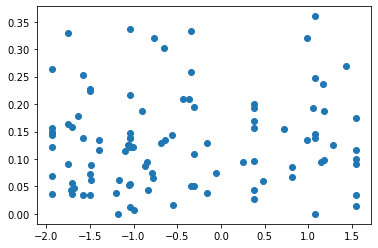

In [141]:
plt.scatter(np.array(data[['y_valence']][:100]), np.array(polarity_list_compound))

In [142]:
mean_affect = []

for i,song in enumerate(tester):
    tokens = set(lemmatizer.lemmatize(word.lower()) for word in tester.iloc[i].split(' '))
    affective_words = list(set(xanew.index).intersection(tokens))
    mean_affect.append(xanew.loc[affective_words].mean())

In [143]:
mean_affect_valence = []
mean_affect_arousal = []
for series in mean_affect:
    #print(series)
    mean_affect_valence.append(series['valence'])
    mean_affect_arousal.append(series['arousal'])

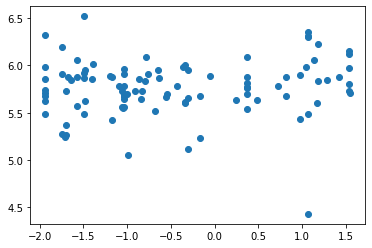

In [145]:
plt.scatter(np.array(data[['y_valence']][:100]), np.array(mean_affect_valence))

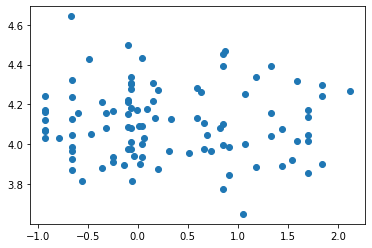

In [146]:
plt.scatter(np.array(data[['y_arousal']][:100]), np.array(mean_affect_arousal))

In [1]:
from lyrics_features import LyricsTable

LyricsTable(regressor = 'linreg')

AttributeError: 'LyricsTable' object has no attribute 'labels_train_ar'

In [136]:
features_index = ['pos', 'neg', 'neu', 'compound']

for i in range(1,151):
    features_index.append(f'tfidf_pca_{i}')
for n in range(151, 351):
    features_index.append(f'anew_pca_{n}')



In [137]:
len(features_index)



354

In [142]:
lyrics_test = pd.read_csv('lyrics_features_val.csv',delimiter = ',')
lyrics_test.columns = features_index
lyrics_test.to_csv('lyrics_features_val.csv', sep = ',')


In [4]:
lyrics_train = pd.read_csv('lyrics_features_train.csv',delimiter = ',')
lyrics_test = pd.read_csv('lyrics_features_test.csv',delimiter = ',')
lyrics_val = pd.read_csv('lyrics_features_val.csv',delimiter = ',')

data = pd.read_csv('merged_cleaned_sentiment_train.csv', delimiter = ',')
data_val = pd.read_csv('merged_cleaned_sentiment_validation.csv', delimiter = ',')
data_test = pd.read_csv('merged_cleaned_sentiment_test.csv', delimiter = ',')


data = pd.concat([data, pd.get_dummies(data.key, drop_first = True, prefix = 'key')], axis=1)
data_val = pd.concat([data_val, pd.get_dummies(data_val.key, drop_first = True, prefix = 'key')], axis=1)
data_test = pd.concat([data_test, pd.get_dummies(data_test.key, drop_first = True, prefix = 'key')], axis=1)

data_multi = pd.concat([data, lyrics_train], axis = 1).dropna(axis = 0)
data_multi_val = pd.concat([data_val, lyrics_val], axis = 1).dropna(axis = 0)
data_multi_test = pd.concat([data_test, lyrics_test], axis = 1).dropna(axis = 0)

data_labels = data_multi[['y_valence', 'y_arousal']]
data_labels_val = data_multi_val[['y_valence', 'y_arousal']]
data_labels_test = data_multi_test[['y_valence', 'y_arousal']]

data_multi = data_multi.drop(columns = ['Unnamed: 0', 'artist', 'trackname', 'id', 'lyrics','lyrics_cleaned', 'neg', 'neu', 'pos', 'compound' ,'y_valence', 'y_arousal'])
data_multi_val = data_multi_val.drop(columns = ['Unnamed: 0', 'artist', 'trackname', 'id', 'lyrics','lyrics_cleaned', 'neg', 'neu', 'pos', 'compound', 'y_valence', 'y_arousal'])
data_multi_test = data_multi_test.drop(columns = ['Unnamed: 0', 'artist', 'trackname', 'id', 'lyrics','lyrics_cleaned', 'neg', 'neu', 'pos', 'compound', 'y_valence', 'y_arousal'])

X_train = data_multi.to_numpy().astype(np.float32)
X_test = data_multi_test.to_numpy().astype(np.float32)
X_val = data_multi_val.to_numpy().astype(np.float32)
y_train = data_labels.to_numpy().astype(np.float32)
y_test = data_labels_test.to_numpy().astype(np.float32)
y_val = data_labels_val.to_numpy().astype(np.float32)




In [246]:
print(X_val.shape, y_val.shape)

(2557, 373) (2557, 2)


In [253]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

reg = LinearRegression(positive= True)
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_test, prediction))

0.8390774465212252
0.16792596949038385


In [7]:
from lyrics_features import LyricsTable

l = LyricsTable(regressor = 'linreg', testset = None, params = [True])

In [10]:
l.features_train = X_train
l.features_test = X_test
l.labels_train_a = y_train[:,1]
l.labels_train_v = y_train[:,0]
l.labels_test_a = y_test[:,1]
l.labels_test_v = y_test[:,0]
l.create_table()

Model: linreg				 R^2
Features		Valence	Arousal


In [237]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)


regr = MLPRegressor(hidden_layer_sizes=(15,15,15), max_iter=1000, random_state = 2)
regr.fit(X_train_norm, y_train)
prediction = regr.predict(X_test_norm)
print(mean_squared_error(y_test, prediction))
print(r2_score(y_val, prediction))

0.88061607
0.1205184828229886


In [234]:
from sklearn.model_selection import GridSearchCV

parameters = {'hidden_layer_sizes':[(5), (10), (15), (5,5), (10,10), (15,15), (5,5,5), (10,10,10), (15,15,15)], 
'max_iter':[500, 1000, 2000, 2500]}

mlp = MLPRegressor(random_state=2)
clf = GridSearchCV(mlp, parameters)
clf.fit(X_train_norm, y_train)

GridSearchCV(estimator=MLPRegressor(random_state=2),
             param_grid={'hidden_layer_sizes': [5, 10, 15, (5, 5), (10, 10),
                                                (15, 15), (5, 5, 5),
                                                (10, 10, 10), (15, 15, 15)],
                         'max_iter': [500, 1000, 2000, 2500]})

In [235]:
np.argmax(clf.cv_results_['mean_test_score'])

clf.cv_results_['params'][33]

{'hidden_layer_sizes': (15, 15, 15), 'max_iter': 1000}

In [188]:
from sklearn.svm import SVR 
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

svr = SVR()
svr.fit(X_train_norm, y_train[:,0])
prediction = svr.predict(X_test_norm)
print(mean_squared_error(y_test[:,0], prediction))
print(r2_score(y_test[:,0], prediction))

1.0284960503008473
0.09149912630243617
